# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
#!pip3 install torch torchvision

#!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]),
                       download=True
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]),
                      download=True
                      )

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64 * 2 * 2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
for param in nn_model.parameters():
    print(param.shape)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, anneal=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        if anneal:
          if not epoch % anneal:
            for g in optimizer.param_groups:
              g['lr'] = g['lr'] * (1 - anneal)
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        if scheduler: scheduler.step()
        
        print("Epoch: %i, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    correct_samples = 0
    total_samples = 0

    for i_step, (x, y) in enumerate(loader):
        model.eval() # Evaluation mode
        # TODO: Copy implementation from previous assignment
        # Don't forget to move the data to device before running it through the model!
        
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu) 

        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]

    accuracy = correct_samples / total_samples
    #raise Exception("Not implemented")
    return accuracy

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 1, Average loss: 1.384517, Train accuracy: 0.537129, Val accuracy: 0.776602
Epoch: 2, Average loss: 0.685986, Train accuracy: 0.790056, Val accuracy: 0.754215
Epoch: 3, Average loss: 0.585471, Train accuracy: 0.824813, Val accuracy: 0.833254
Epoch: 4, Average loss: 0.536867, Train accuracy: 0.839846, Val accuracy: 0.836462
Epoch: 5, Average loss: 0.506207, Train accuracy: 0.851943, Val accuracy: 0.838168


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [7]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs,
                       download=True
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Using downloaded and verified file: ./train_32x32.mat


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

Using downloaded and verified file: ./train_32x32.mat


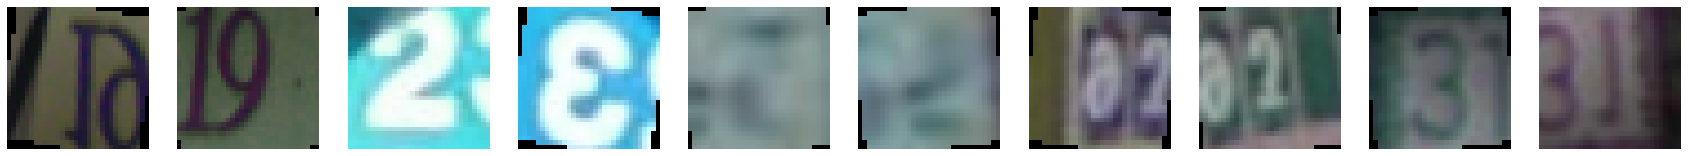

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs,
                       download=True
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [8]:
# TODO: 
cust_tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),                #selected
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),     #selected
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose

data_cust_aug_train = dset.SVHN('./', 
                       transform=cust_tfs,
                       download=True
                      )

train_cust_aug_loader = torch.utils.data.DataLoader(data_cust_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Using downloaded and verified file: ./train_32x32.mat


In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_cust_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 1, Average loss: 0.597236, Train accuracy: 0.815804, Val accuracy: 0.839124
Epoch: 2, Average loss: 0.552423, Train accuracy: 0.831826, Val accuracy: 0.842878
Epoch: 3, Average loss: 0.533047, Train accuracy: 0.836860, Val accuracy: 0.848952
Epoch: 4, Average loss: 0.518817, Train accuracy: 0.841518, Val accuracy: 0.849771
Epoch: 5, Average loss: 0.502874, Train accuracy: 0.847865, Val accuracy: 0.840625


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
# input [batch_size=64, n_channels=3, width=32, height=32]
lenet_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),         #out=[(32-5)+1:28x28]
    nn.Tanh(),
    nn.AvgPool2d(2),                                                            #out=[(28-2)/2+1:14x14]
    
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),        #out=[(14-5)+1:10x10]
    nn.Tanh(),
    nn.AvgPool2d(2),                                                            #out=[(10-2)/2+1:5x5]

    Flattener(),
    
    nn.Linear(16 * 5 * 5, 140),
    nn.Tanh(),
    nn.Linear(140, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
print(f'Batch size and shape of input are: {train_cust_aug_loader.batch_size} and {train_cust_aug_loader.dataset.data.shape}')

Batch size and shape of input are: 64 and (73257, 3, 32, 32)


In [ ]:
params_reset(lenet_model)

#Epoch: 1, Average loss: 0.492229, Train accuracy: 0.848701, Val accuracy: 0.858781
#Epoch: 2, Average loss: 0.450788, Train accuracy: 0.860629, Val accuracy: 0.873729
#Epoch: 3, Average loss: 0.423045, Train accuracy: 0.869109, Val accuracy: 0.866357

loss_history, train_history, val_history = train_model(lenet_model, train_cust_aug_loader, val_loader, loss, optimizer, 3)

reset 0:Conv2d
skip  1:Tanh
skip  2:AvgPool2d
reset 3:Conv2d
skip  4:Tanh
skip  5:AvgPool2d
skip  6:Flattener
reset 7:Linear
skip  8:Tanh
reset 9:Linear
skip  10:Tanh
reset 11:Linear
Epoch: 1, Average loss: 2.070863, Train accuracy: 0.269529, Val accuracy: 0.626510
Epoch: 2, Average loss: 0.775839, Train accuracy: 0.759376, Val accuracy: 0.818511
Epoch: 3, Average loss: 0.553782, Train accuracy: 0.829608, Val accuracy: 0.849157


In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_cust_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 1, Average loss: 0.341699, Train accuracy: 0.895045, Val accuracy: 0.885673
Epoch: 2, Average loss: 0.332645, Train accuracy: 0.897178, Val accuracy: 0.869497
Epoch: 3, Average loss: 0.324518, Train accuracy: 0.900386, Val accuracy: 0.888335
Epoch: 4, Average loss: 0.310995, Train accuracy: 0.902928, Val accuracy: 0.893113
Epoch: 5, Average loss: 0.304244, Train accuracy: 0.905880, Val accuracy: 0.881100


In [ ]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

lenet_model.apply(weight_init)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flattener()
  (7): Linear(in_features=400, out_features=140, bias=True)
  (8): Tanh()
  (9): Linear(in_features=140, out_features=84, bias=True)
  (10): Tanh()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def params_reset(model):
  for number, module in model.named_children():
      try:
        module.reset_parameters()
        #print(f'reset {number}:{module.__class__.__name__}')
      except nn.modules.module.ModuleAttributeError:
        #print(f'skip  {number}:{module.__class__.__name__}')
        pass
  print('\nparams were reseted')

# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

#learning_rates = np.logspace(1, 4, num=5, base=.1)
#reg = np.logspace(1, 2.5, num=5, base=1e-3)

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5]#, 15, 20, 50]
reg = [1e-3, 1e-4]

batch_size = 64
epoch_num = 10


# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

for lr in learning_rates:
    for rg in reg:
      for ae in anneal_epochs:
          
          params_reset(lenet_model)

          hyperp = Hyperparams(lr, ae, rg)
          
          print(f'\n! Started new iter with lr: {hyperp.learning_rate}, reg: {hyperp.reg} and anneal: {hyperp.anneal_epochs} !\n')

          optimizer = optim.SGD(lenet_model.parameters(), 
                                lr=hyperp.learning_rate, 
                                weight_decay=hyperp.reg)

          scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                step_size=hyperp.anneal_epochs, 
                                                gamma=anneal_coeff)
              
          loss_history, train_history, val_history = train_model(lenet_model, 
                                                                train_cust_aug_loader, 
                                                                val_loader, 
                                                                loss, 
                                                                optimizer, 
                                                                epoch_num,
                                                                scheduler=scheduler)
                                                                
              
          run_record[hyperp] = RunResult(lenet_model, train_history, val_history, val_history[-1].item())



params were reseted

! Started new iter with lr: 1.0, reg: 0.001 and anneal: 1 !

Epoch: 1, Average loss: 5.103462, Train accuracy: 0.144269, Val accuracy: 0.109754
Epoch: 2, Average loss: 2.164613, Train accuracy: 0.218271, Val accuracy: 0.276978
Epoch: 3, Average loss: 1.904269, Train accuracy: 0.332850, Val accuracy: 0.364890
Epoch: 4, Average loss: 1.814382, Train accuracy: 0.371208, Val accuracy: 0.379974
Epoch: 5, Average loss: 1.794502, Train accuracy: 0.379381, Val accuracy: 0.382773
Epoch: 6, Average loss: 1.787616, Train accuracy: 0.383169, Val accuracy: 0.384342
Epoch: 7, Average loss: 1.787580, Train accuracy: 0.382930, Val accuracy: 0.384888
Epoch: 8, Average loss: 1.786419, Train accuracy: 0.383357, Val accuracy: 0.384957
Epoch: 9, Average loss: 1.787575, Train accuracy: 0.382350, Val accuracy: 0.384888
Epoch: 10, Average loss: 1.789056, Train accuracy: 0.382572, Val accuracy: 0.384888

params were reseted

! Started new iter with lr: 1.0, reg: 0.001 and anneal: 5 !

Epo

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.89, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.0001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [12]:
epoch_num = 10

best_model = nn.Sequential(
    
    nn.BatchNorm2d(3),
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),        #out=[(32-3+2*1)+1:32x32]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),                                                            #out=[(32-2)/2+1:16x16]
    
    nn.BatchNorm2d(16),
    nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1),       #out=[(16-3+2*1)+1:16x16]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),                                                            #out=[(16-2)/2+1:8x8]

    nn.BatchNorm2d(24),
    nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1),       #out=[(8-3+2*1)+1:8x8]
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),                                                            #out=[(8-2)/2+1:4x4]

    Flattener(),
    
    nn.Linear(32 * 4 * 4, 140),
    nn.ReLU(inplace=True),

    nn.Linear(140, 84),
    nn.ReLU(inplace=True),

    nn.Linear(84, 10),
)

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.SGD(best_model.parameters(), 
#                      lr=1e-1, 
#                      weight_decay=1e-4)

optimizer = optim.Adam(best_model.parameters(), 
                       lr=1e-3, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-4, 
                       amsgrad=False)

loss_history, train_history, val_history = train_model(best_model, 
                                                        train_cust_aug_loader, 
                                                        val_loader, 
                                                        loss, 
                                                        optimizer, 
                                                        epoch_num)

#.906354
#.915774(.920142)
##adam
#.923950

Epoch: 1, Average loss: 0.976829, Train accuracy: 0.675903, Val accuracy: 0.829431
Epoch: 2, Average loss: 0.496852, Train accuracy: 0.846654, Val accuracy: 0.879803
Epoch: 3, Average loss: 0.418713, Train accuracy: 0.870201, Val accuracy: 0.886356
Epoch: 4, Average loss: 0.380134, Train accuracy: 0.882981, Val accuracy: 0.894751
Epoch: 5, Average loss: 0.348635, Train accuracy: 0.893185, Val accuracy: 0.893386
Epoch: 6, Average loss: 0.326421, Train accuracy: 0.899857, Val accuracy: 0.901167
Epoch: 7, Average loss: 0.309469, Train accuracy: 0.904105, Val accuracy: 0.908675
Epoch: 8, Average loss: 0.294590, Train accuracy: 0.909088, Val accuracy: 0.905399
Epoch: 9, Average loss: 0.282537, Train accuracy: 0.912603, Val accuracy: 0.904853
Epoch: 10, Average loss: 0.271898, Train accuracy: 0.917346, Val accuracy: 0.912156


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [14]:
# TODO Write the code to compute accuracy on test set

test_size = data_test.data.shape[0]
test_sampler = SubsetRandomSampler(list(range(test_size)))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         sampler=test_sampler)

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  tensor(0.9110, device='cuda:0')
